In [72]:
%matplotlib inline
%run __init__.py
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas
import utils
from utils import loading, scoring
from gerkin import dream,fit1,fit2,params

In [73]:
descriptors = loading.get_descriptors(format=True)
letters = utils.letters
all_CIDs = sorted(loading.get_CIDs(['training','leaderboard']))
all_CID_dilutions = sorted(loading.get_CID_dilutions(['training','leaderboard']))
norep_CID_dilutions = sorted(loading.get_CID_dilutions(['training-norep','leaderboard']))
rep_CIDs = sorted(loading.get_CIDs(['replicated']))
rep_CID_dilutions = sorted(loading.get_CID_dilutions(['replicated']))
features = loading.get_molecular_data(['dragon','morgan'],all_CIDs)

Dragon has 4869 features for 476 molecules.
Morgan has 2437 features for 407 molecules.
There are now 7306 total features.


### Load data and parameters

In [74]:
X,_,_,_,_,_ = dream.make_X(features,all_CID_dilutions)
X_train = X.loc[norep_CID_dilutions]
X_test_other = dream.filter_X_dilutions(X.loc[rep_CID_dilutions],target_dilution='high')
X_test_int = dream.filter_X_dilutions(X.loc[rep_CID_dilutions],target_dilution=-3)

The X matrix now has shape (745x5497) molecules by non-NaN good molecular descriptors


In [75]:
# Same as above, but preparing data for the linear model
X_lin = dream.quad_prep(features,all_CID_dilutions)
X_train_lin = X_lin.loc[norep_CID_dilutions]
X_test_lin_other = dream.quad_prep(features,rep_CID_dilutions,dilution='high')
X_test_lin_int = dream.quad_prep(features,rep_CID_dilutions,dilution=-3)

The X matrix now has shape (745x14614) molecules by non-NaN good molecular descriptors
The X matrix now has shape (20x14614) molecules by non-NaN good molecular descriptors
The X matrix now has shape (15x14614) molecules by non-NaN good molecular descriptors


In [122]:
Y_train = loading.load_perceptual_data(['training-norep','leaderboard'])
Y_train_imp = dream.impute(Y_train['Subject'],'median').unstack('Descriptor')
Y_test = loading.load_perceptual_data(['replicated'])
Y_test_other = dream.filter_Y_dilutions(Y_test,'low')
Y_test_int = dream.filter_Y_dilutions(Y_test,-3)
Y_test_gold = dream.filter_Y_dilutions(Y_test,'gold',keep_replicates=True)

In [77]:
# Load optimal parameters (from cross-validation) for random forest model
trans_params = params.get_trans_params(Y_train, descriptors, plot=False)
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()

In [78]:
# Create a mask to indicate which molecules have intensity values at 1/1000 dilution
intensity_mask = [x[0] for x in loading.get_CID_dilutions('replicated') if x[1]==-3]

## Subchallenge 1

### Load or run random forest model

In [79]:
use_saved_rf_model = True
if use_saved_rf_model:
    with open('../../data/rfcs_norep_1.pickle','rb') as f:
        rfcs_norep_1 = pickle.load(f)
else:
    n_estimators = 25
    rfcs_norep_1,score_1,rs_1 = fit1.rfc_final(X_train,Y_train_imp,
                                max_features,min_samples_leaf,max_depth,use_et,regularize,
                                n_estimators=n_estimators)
    with open('../../data/rfcs_norep_1.pickle','wb') as f:
        pickle.dump(rfcs_norep_1,f)

In [80]:
# Use the model to create the prediction arrays
Y_pred_dec = loading.make_prediction_files(rfcs_norep_1,X_test_int,X_test_other,
                                         'replicated',1,intensity_mask=intensity_mask,Y_test=None,
                                          write=False,regularize=regularize)

In [81]:
# Print a summary of the prediction quality
predicted = Y_pred_dec.to_frame()
observed = dream.filter_Y_dilutions(Y_test,'gold')['Subject']
scoring.score_summary(predicted,observed,mask=True)

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:882: RuntimeWarning: invalid value encountered in less
  return umath.less(x, self.critical_value)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


'Score: 2.872131; rs = 0.000,0.126,0.006'

### Linear (Quadratic) model

In [82]:
# Load or compute the feature ranks for the training set
use_saved_linear_feature_ranks = True
if use_saved_linear_feature_ranks:
    lin_ranked = np.load('../../data/lin_ranked_test_retest.npy')
else:
    # -1 is to leave out the leak feature
    lin_ranked = fit2.compute_linear_feature_ranks(X_train_lin,Y_train,n_resampling=10)
    np.save('../../data/lin_ranked_test_retest',lin_ranked)

In [83]:
# Run the linear model (fast)
Y_pred_lin = fit1.compute_linear_predictions(X_train_lin,X_test_lin_int,X_test_lin_other,Y_train_imp,
                                lin_ranked,alpha=10.0,max_features=1000)

95.24% [------------------------------------------------  ]

### Make a consensus model and then compute correlations

In [84]:
# Use an average of the two models as the prediction
y_pred = Y_pred_dec.copy()
for subject in range(1,50):
    y_pred[subject] = (Y_pred_dec[subject]+Y_pred_lin[subject])/2

In [170]:
# Compute model/test correlations and test/retest correlations

# Extract the indices of the 20 replicated molecules.  
#rep_indices = np.where(data[0,:,1,:,0].mean(axis=1).mask == False)[0]

# Subchallenge 1: Jacknife samples of the Coefficients of Error.
sc1_cv = pd.Series(index=descriptors) # Will hold Model vs. Test
trt1_cv = pd.Series(index=descriptors) # Will hold Test vs Retest

for d,descriptor in enumerate(descriptors): # Iterate over each descriptor.  
    rs_sc1 = pd.Series(index=range(1,50)) # Hold model vs test correlations for each the 49 subjects.  
    rs_trt = pd.Series(index=range(1,50)) # Hold test vs retest correlations for each the 49 subjects.  
    for subject in range(1,50): # Iterate over subjects.  
        o = Y_test_gold['Subject'][subject].unstack('CID').loc[(descriptor,0)]
        r = Y_test_gold['Subject'][subject].unstack('CID').loc[(descriptor,1)]
        p = y_pred[subject][descriptor] # Select the predicted values for the same molecules.   
        
        # To avoid biasing towards test or retest, compute the length-40 vector of concatenated test and retest
        # values for this subject/descriptor.  Compute correlated of corresponding length-40 vector which just has
        # the 20 predicted values listed twice.  
        rs_sc1[subject] = pd.concat((o,r)).corr(pd.concat((p,p)))
        
        # Now compute correlation between test and retest.  
        rs_trt[subject] = o.corr(r)
    
    # Compute the mean across subjects of these within-subject correlations.
    sc1_cv[descriptor] = rs_sc1.mean()
    trt1_cv[descriptor] = rs_trt.mean()

In [202]:
# Same as above, but to compute jacknife samples to get error bars.

sc1_cv_jn = pd.DataFrame(index=rep_CIDs,columns=descriptors) # Will hold Model vs. Test
trt1_cv_jn = pd.DataFrame(index=rep_CIDs,columns=descriptors) # Will hold Test vs Retest

for d,descriptor in enumerate(descriptors): # Iterate over each descriptor.  
    CIDs = list(set(Y_test_gold.loc[descriptor].index.get_level_values('CID')))
    for i,CID in enumerate(CIDs): # Which CID to holdout for jackknife estimation
        rs_sc1 = pd.Series(index=range(1,50)) # Hold model vs test correlations for each the 49 subjects.  
        rs_trt = pd.Series(index=range(1,50)) # Hold test vs retest correlations for each the 49 subjects.  
        for subject in range(1,50): # Iterate over subjects.  
            o = Y_test_gold['Subject'][subject].unstack('CID').loc[(descriptor,0)].drop(CID)
            r = Y_test_gold['Subject'][subject].unstack('CID').loc[(descriptor,1)].drop(CID)
            p = y_pred[subject][descriptor].drop(CID) # Select the predicted values for the same molecules.   
            rs_sc1[subject] = pd.concat((o,r)).corr(pd.concat((p,p)))
            rs_trt[subject] = o.corr(r)

        sc1_cv_jn.loc[CID,descriptor] = rs_sc1.mean()
        trt1_cv_jn.loc[CID,descriptor] = rs_trt.mean()

In [204]:
# Make sure that means of jackknife samples are approximately equal to directly computed means
assert np.allclose(sc1_cv,sc1_cv_jn.mean(axis=0),atol=0.05)
assert np.allclose(trt1_cv,trt1_cv_jn.mean(axis=0),atol=0.05)

In [205]:
from scipy.odr import Model,RealData,ODR

In [231]:
# Code for plotting the test-retest plot
def plot_r(sc_mean,trt_mean,subchallenge,sc_err=None,trt_err=None,scale='auto'):
    plt.figure(figsize=(12,12))
    x = np.linspace(-1,1,100)
    plt.plot(x,x,'--',c='r',linewidth=4)
    plt.errorbar(trt_mean,sc_mean,xerr=trt_err,yerr=sc_err,c='white',ecolor='black',fmt='o',markersize=24)  
    plt.xlabel('Test-Retest Correlation',size=30)
    plt.ylabel('Model-Test Correlation',size=30)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    from scipy.stats import linregress, ttest_rel
    _,p = ttest_rel(sc_mean,trt_mean)
    r = np.corrcoef(sc_mean,trt_mean)[0,1]
    z = np.zeros(100) # Add 0's for stability
    
    # Orthogonal distance regression (uses uncertainties)
    def lin_func(p, x):
        m, b = p
        return m*x + b
    data = RealData(np.concatenate((z,trt_mean)), np.concatenate((z,sc_mean)), 
                    sx=np.concatenate((z+0.01,trt_err)), sy=np.concatenate((z+0.01,sc_err)))
    lin_model = Model(lin_func)
    odr = ODR(data, lin_model, beta0=[1., 0.])
    out = odr.run()
    
    # Plain linear regression (does not use uncertainties)
    coefs = linregress(np.concatenate((z,trt_mean)),np.concatenate((z,sc_mean))) # Zeros force the intercept to be zero
    
    slope = out.beta[0] # coefs.slope
    stderr = out.sd_beta[0] # coefs.stderr
    intercept = out.beta[1] # coefs.intercept
    plt.plot(x,x*slope + intercept,'-',c='k')
    plt.text(0.01,0.45,'slope = %.2f+/-%.2f' % (slope,stderr),size=22)
    for d,descriptor in enumerate(descriptors):
        plt.text(trt_mean[descriptor],sc_mean[descriptor],letters[d],fontdict={'color':'blue','size':21,'weight':'bold'},
                 horizontalalignment='center',verticalalignment='center')

## Fig. 5B

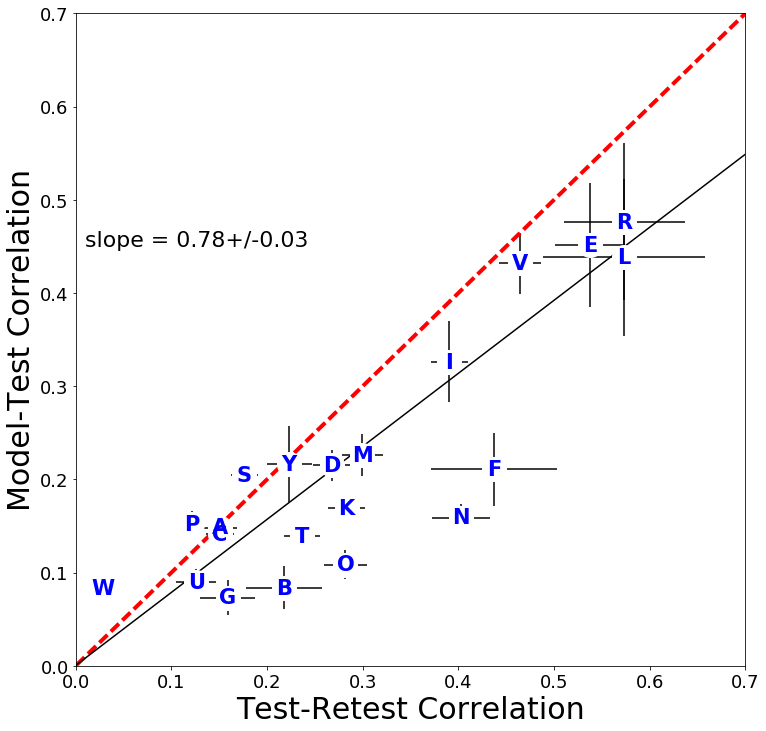

In [232]:
plot_r(sc1_cv_jn.mean(axis=0),trt1_cv_jn.mean(axis=0),1,sc_err=sc1_cv_jn.std(axis=0),trt_err=trt1_cv_jn.std(axis=0))
plt.tick_params(axis='both', which='major', labelsize=18)
#plt.savefig('../../figures/test-retest_sc1.eps',format='eps')

In [319]:
# p-values for each of the points in the plot
# Compared against the null-hypothesis that they are on the line
from scipy.stats import multivariate_normal,chi2
n_rvs = 1000000
def compute_pvals(sc_cv_jn,trt_cv_jn):
    ps = pd.Series(index=descriptors)
    for descriptor in descriptors:
        rvs = multivariate_normal.rvs([sc_cv_jn.mean(axis=0)[descriptor],trt_cv_jn.mean(axis=0)[descriptor]],
                                      [[sc_cv_jn.std(axis=0)[descriptor]**2,0],
                                       [0,trt_cv_jn.std(axis=0)[descriptor]**2]],
                                      n_rvs)
        ps[descriptor] = ((rvs[:,1] - rvs[:,0]) < 0).sum()/n_rvs
    ps_fdr = pd.Series(index=descriptors)
    for descriptor in descriptors:
        ps_fdr[descriptor] = ps[descriptor] * len(descriptors) / (ps.rank()[descriptor])
        if ps_fdr[descriptor] < 0.001: 
            stars = '***'
        elif ps_fdr[descriptor] < 0.01: 
            stars = '**'
        elif ps_fdr[descriptor] < 0.05: 
            stars = '*'
        else:
            stars = ''
        print("%s: %.4f %s" % (descriptor,ps_fdr[descriptor],stars))

    fisher = -np.log(ps).sum()*2
    print("Pooled p = %.3g" % (1-chi2.cdf(fisher,42)))

    fisher = -np.log(ps.drop('Intensity')).sum()*2
    print("Pooled p = %.3g (ignoring intensity)" % (1-chi2.cdf(fisher,42)))

    fisher = -np.log(ps.drop(['Intensity','Pleasantness'])).sum()*2
    print("Pooled p = %.3g (ignoring intensity and pleasantness)" % (1-chi2.cdf(fisher,42)))
    
compute_pvals(sc1_cv_jn,trt1_cv_jn)

ValueError: array must not contain infs or NaNs

## Subchallenge 2

In [280]:
use_saved_rf_model = False
if use_saved_rf_model:
    with open('../../data/rfcs_norep_2.pickle','rb') as f:
        rfcs_norep_2 = pickle.load(f)
else:
    n_estimators = 3
    rfcs_norep_2,score_2,rs_2 = fit2.rfc_final(X_train,Y_train_imp,Y_train,
                                max_features,min_samples_leaf,max_depth,use_et,use_mask,trans_weight,trans_params,
                                n_estimators=n_estimators)
    with open('../../data/rfcs_norep_2.pickle','wb') as f:
        pickle.dump(rfcs_norep_1,f)

97.62% [------------------------------------------------- ]

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.

For subchallenge 2:
	Score = 0.00
	int_mean = 0.000
	int_std = 0.000
	ple_mean = 0.000
	ple_std = 0.000
	dec_mean = 0.000
	dec_std = 0.000


In [282]:
# Use the model to create the prediction arrays
Y_pred_dec = loading.make_prediction_files(rfcs_norep_2,X_test_int,X_test_other,
                                         'replicated',2,intensity_mask=intensity_mask,Y_test=None,
                                          write=False)

In [285]:
# Print a summary of the prediction quality
predicted = Y_pred_dec.to_frame()
observed = dream.filter_Y_dilutions(Y_test,'gold')['Subject']
scoring.score_summary2(predicted,observed,mask=True)

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:882: RuntimeWarning: invalid value encountered in less
  return umath.less(x, self.critical_value)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


'Score: -0.100181; rs = 0.000,0.492,-0.031,0.000,-0.345,-0.009'

In [287]:
Y_pred_dec

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 20 (major_axis) x 21 (minor_axis)
Items axis: mean to std
Major_axis axis: 460 to 5363491
Minor_axis axis: Intensity to Chemical

In [313]:
# Use an average of the two models as the prediction
y_pred = (Y_pred_dec['mean'] + Y_pred_lin.mean(axis=0))/2

In [314]:
# Compute model/test correlations and test/retest correlations

# Extract the indices of the 20 replicated molecules.  
#rep_indices = np.where(data[0,:,1,:,0].mean(axis=1).mask == False)[0]

# Subchallenge 1: Jacknife samples of the Coefficients of Error.
sc2_cv = pd.Series(index=descriptors) # Will hold Model vs. Test
trt2_cv = pd.Series(index=descriptors) # Will hold Test vs Retest

for d,descriptor in enumerate(descriptors): # Iterate over each descriptor.  
    o = Y_test_gold.mean(axis=1).unstack('CID').loc[(descriptor,0)]
    r = Y_test_gold.mean(axis=1).unstack('CID').loc[(descriptor,1)]
    p = y_pred[descriptor] # Select the predicted values for the same molecules.   
        
    # To avoid biasing towards test or retest, compute the length-40 vector of concatenated test and retest
    # values for this subject/descriptor.  Compute correlated of corresponding length-40 vector which just has
    # the 20 predicted values listed twice.  
    rs_sc2 = pd.concat((o,r)).corr(pd.concat((p,p)))

    # Now compute correlation between test and retest.  
    rs_trt = o.corr(r)
    
    sc2_cv[descriptor] = rs_sc2
    trt2_cv[descriptor] = rs_trt

In [315]:
# Same as above, but to compute jacknife samples to get error bars.

sc2_cv_jn = pd.DataFrame(index=rep_CIDs,columns=descriptors) # Will hold Model vs. Test
trt2_cv_jn = pd.DataFrame(index=rep_CIDs,columns=descriptors) # Will hold Test vs Retest

for d,descriptor in enumerate(descriptors): # Iterate over each descriptor.  
    CIDs = list(set(Y_test_gold.loc[descriptor].index.get_level_values('CID')))
    for i,CID in enumerate(CIDs): # Which CID to holdout for jackknife estimation
        o = Y_test_gold.mean(axis=1).unstack('CID').loc[(descriptor,0)].drop(CID)
        r = Y_test_gold.mean(axis=1).unstack('CID').loc[(descriptor,1)].drop(CID)
        p = y_pred[descriptor].drop(CID) # Select the predicted values for the same molecules.  
        rs_sc2 = pd.concat((o,r)).corr(pd.concat((p,p)))
        rs_trt = o.corr(r)
        sc2_cv_jn.loc[CID,descriptor] = rs_sc2
        trt2_cv_jn.loc[CID,descriptor] = rs_trt

In [316]:
# Make sure that means of jackknife samples are approximately equal to directly computed means
assert np.allclose(sc2_cv,sc2_cv_jn.mean(axis=0),atol=0.05)
assert np.allclose(trt2_cv,trt2_cv_jn.mean(axis=0),atol=0.05)

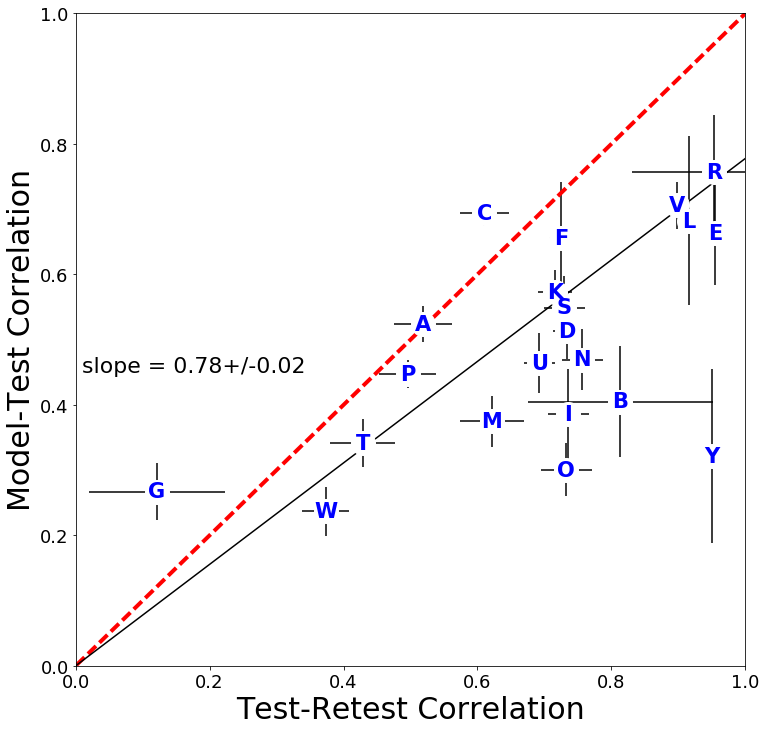

In [318]:
plot_r(sc2_cv,trt2_cv,1,sc2_cv_jn.std(axis=0),trt_err=trt2_cv_jn.std(axis=0))
plt.xlim(0,1.0)
plt.ylim(0,1.0);
plt.tick_params(axis='both', which='major', labelsize=18);
#plt.savefig('../../figures/test-retest_sc2.eps',format='eps')

In [320]:
compute_pvals(sc2_cv_jn,trt2_cv_jn)

Intensity: 0.0000 ***
Pleasantness: 0.0000 ***
Bakery: 0.0130 *
Sweet: 0.0002 ***
Fruit: 0.1483 
Fish: 0.2068 
Garlic: 0.0415 *
Spices: 0.2003 
Cold: 0.9790 
Sour: 0.0014 **
Burnt: 0.0000 ***
Acid: 0.5926 
Warm: 0.0063 **
Musky: 0.0007 ***
Sweaty: 0.1051 
Ammonia: 0.0000 ***
Decayed: 0.0000 ***
Wood: 0.0000 ***
Grass: 0.9427 
Flower: 0.0000 ***
Chemical: 0.0001 ***
Pooled p = 0
Pooled p = 0 (ignoring intensity)
Pooled p = 0 (ignoring intensity and pleasantness)


/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log


### This is what it would look like if model/test correlation was equal to test/retest correlation:

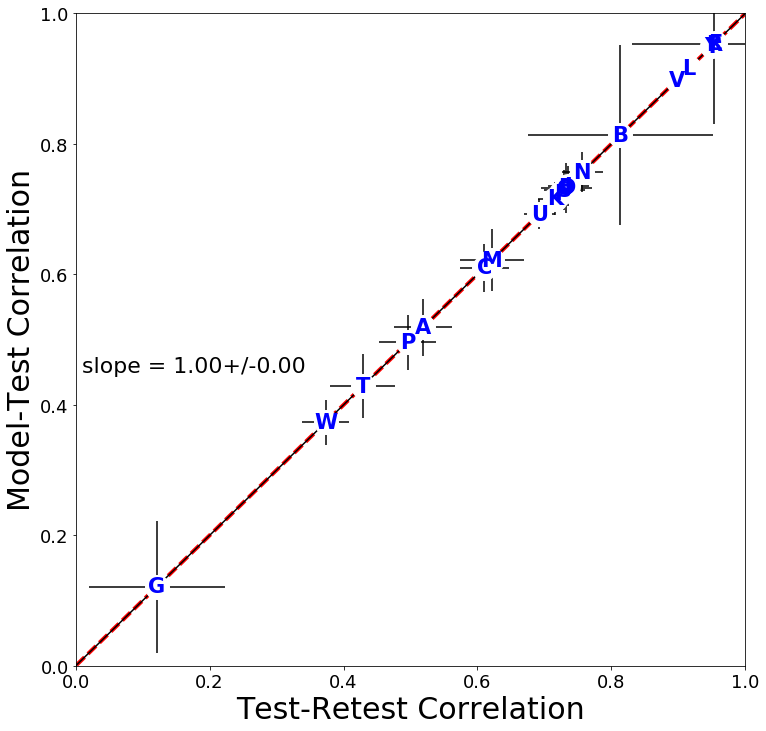

In [325]:
plot_r(trt2_cv,trt2_cv,1,trt2_cv_jn.std(axis=0),trt_err=trt2_cv_jn.std(axis=0))
plt.xlim(0,1.0)
plt.ylim(0,1.0);
plt.tick_params(axis='both', which='major', labelsize=18);
#plt.savefig('../../figures/test-retest_cartoon_2.eps',format='eps')

### This is what it would look like if model/test correlation was approximately zero (random model):

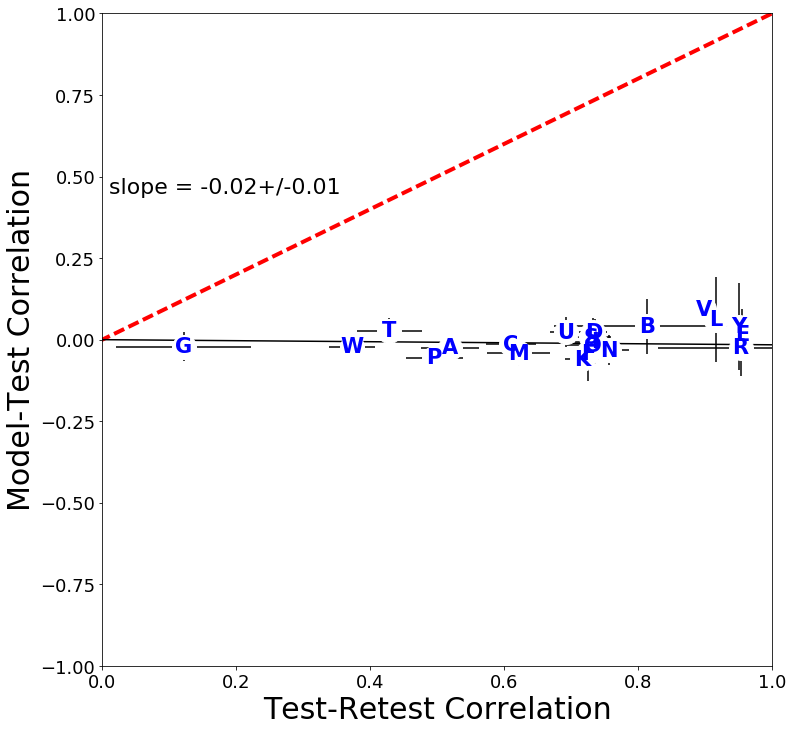

In [339]:
plot_r(pd.Series(index=descriptors,data=np.random.randn(21)/25),trt2_cv,1,sc2_cv_jn.std(axis=0),trt_err=trt2_cv_jn.std(axis=0))
plt.xlim(0,1.0)
plt.ylim(-1.0,1.0);
plt.tick_params(axis='both', which='major', labelsize=18);
#plt.savefig('../../figures/test-retest_sc2.eps',format='eps')